In [1]:
from ultralytics import YOLO

from typing import Dict, Union, Tuple, List, Optional
from collections import Counter
import os
from PIL import Image

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Гиперпараметры

In [81]:
# Параметры для тестирования
COMPARE_BY_COUNT = True  # Сравнивать по количеству, иначе по conf(достоверности предсказания)
TEST_PARAMS = {
    'verbose': False,
    'conf': 0.25,  # порог достоверности обнаружения объекта, default=0.25
    'iou': 0.99,  # пересечение порога объединения (IOU), default=0.7
}

Проверка GPU

In [23]:
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.211  Python-3.11.5 torch-2.1.1+cpu CPU (Intel Core(TM) i5-3470 3.20GHz)
Setup complete  (4 CPUs, 8.0 GB RAM, 125.5/431.0 GB disk)


In [4]:
import torch

cuda_flag = torch.cuda.is_available()
device = 'cuda' if cuda_flag else 'cpu'
device

'cpu'

Необходимые функции

In [30]:
def show_pred_img(preds: list, index_show: int) -> None:
    """Результат работы модели на одной картинке"""
    img = preds[index_show].plot()
    img = Image.fromarray(img[..., ::-1])
    # display(img)
    plt.figure(figsize=(5,5))
    plt.axis('off')
    plt.imshow(img)

In [43]:
def softmax(x: list) -> float:
    """"""
    return np.exp(x) / sum(np.exp(x))


def _recalculation_dict_summator(summator: dict) -> dict:
    """Перерасчёт аналитического словаря в вероятностном виде."""
    conf_list = softmax(list(summator.values()))
    for i, key in enumerate(summator.keys()):
        summator[key] = conf_list[i]
    return summator


def analyse_target_class_by_count(
        classes: list,
        conf: list = None,
) -> tuple[Optional[str], Optional[float]]:
    """Обобщение класса изображения по наибольшему количеству.
    return:
        best_class: Optional[str] - самый вероятный класс.
        best_conf: Optional[float] - вероятность итогового класса."""
    summator = {}
    for i in range(len(classes)):

        name_class = str(classes[i])
        if name_class not in summator:
            summator[name_class] = 1
        else:
            summator[name_class] += 1

    summator = _recalculation_dict_summator(summator)
    best_class = max(summator, key=summator.get) if summator else None
    best_conf = summator.get(best_class, None)
    return (best_class, best_conf)


def predict_one_class(
    model,
    true_target: str,
    path,
    lst_filename_images: list,
) -> float:

    preds = []
    counter_true = 0
    for filename in lst_filename_images:
        new_path = os.path.join(path, filename)

        results = model.predict(new_path, device=device, **TEST_PARAMS)
        result = results[0]

        preds.append(result)

        classes = []
        for i in result.boxes.cls:
            classes.append(model.names[int(i)])

        pred_target, _ = analyse_target_class_by_count(classes)
        if pred_target == true_target:
            counter_true += 1

    return counter_true / len(lst_filename_images), preds

In [50]:
DATASET_DIR = 'test_dataset'

path_background = os.path.join(DATASET_DIR, 'background')
filenames_images_background = os.listdir(path_background)

path_brick = os.path.join(DATASET_DIR, 'brick')
filenames_images_brick = os.listdir(path_brick)

path_concrete = os.path.join(DATASET_DIR, 'concrete')
filenames_images_concrete = os.listdir(path_concrete)

path_ground = os.path.join(DATASET_DIR, 'ground')
filenames_images_ground = os.listdir(path_ground)

path_tree = os.path.join(DATASET_DIR, 'tree')
filenames_images_tree = os.listdir(path_tree)

In [53]:
test_lst = [
    [None, path_background, filenames_images_background],
    ['Кирпич', path_brick, filenames_images_brick],
    ['Бетон', path_concrete, filenames_images_concrete],
    ['Грунт', path_ground, filenames_images_ground],
    ['Дерево', path_tree, filenames_images_tree]
]

# Predict

In [54]:
model = YOLO('./weights/full_dataset_yolo8s_rs1/weights/full_dataset_yolo8s_rs1.pt')
models = [model]

In [58]:
avg_accuracy = 0
for model in models:
    for lst in test_lst:
        pred, preds = predict_one_class(model, *lst)
        avg_accuracy += pred
        print(f'{lst[0]} ', f'{pred = }')

avg_accuracy = avg_accuracy / len(test_lst)
print(f'{avg_accuracy = }')

None  pred = 0.8666666666666667
Кирпич  pred = 0.9
Бетон  pred = 0.8181818181818182
Грунт  pred = 1.0
Дерево  pred = 1.0
avg_accuracy = 0.916969696969697


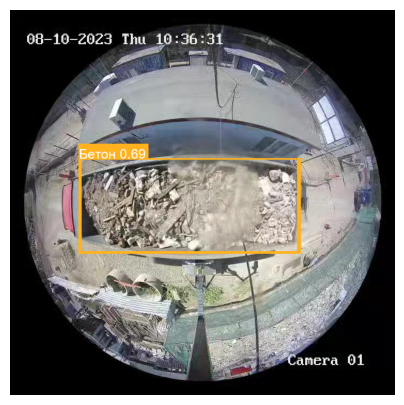

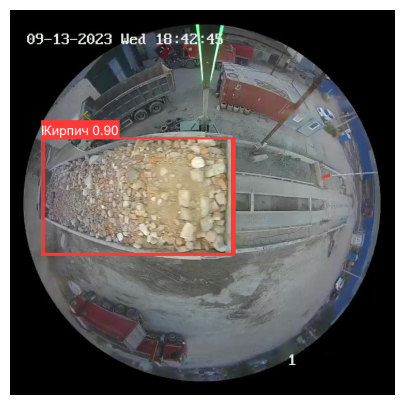

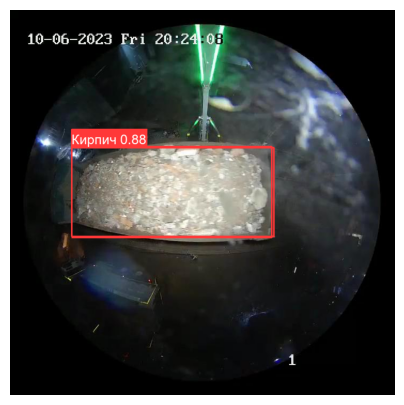

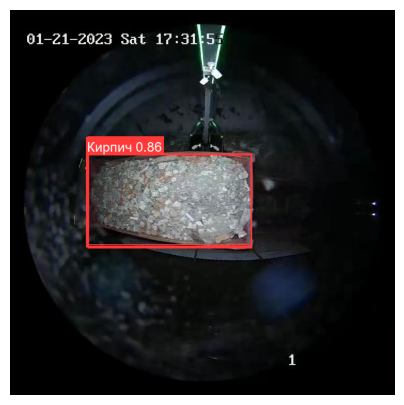

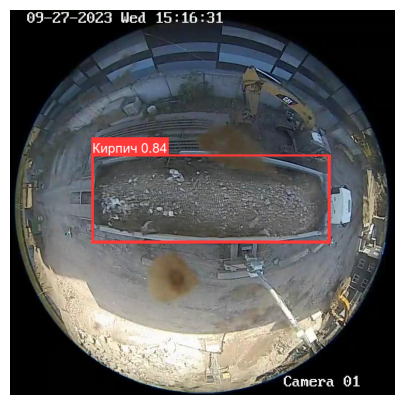

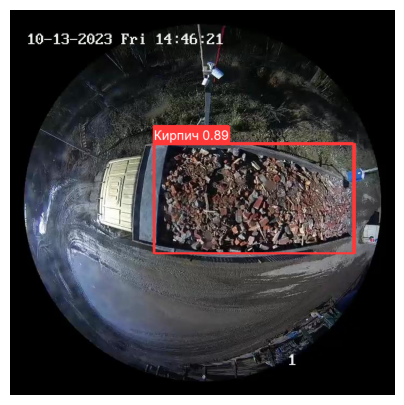

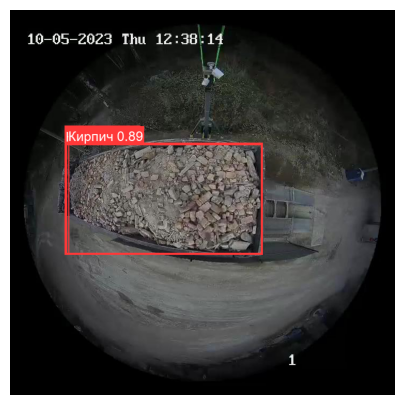

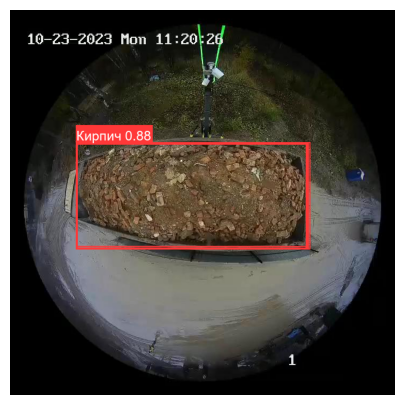

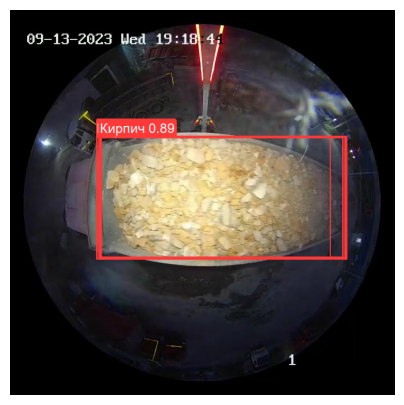

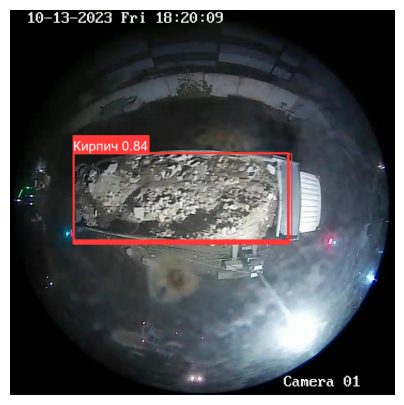

In [49]:
lst = preds_brick 

for i in range(len(lst)):
    show_pred_img(lst, i)

# Ensemble

In [73]:
from ensemble_boxes import *
import cv2
from random import randint


def draw_boxes_from_list(path_to_image, boxes, labels, colors, names):
    image = cv2.imread(path_to_image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    height, width, _ = image.shape

    for object_, label_ in zip(boxes, labels):
        color = colors[int(label_)]
        x_min, y_min, x_max, y_max = object_
        x_min = int(x_min * width)
        y_min = int(y_min * height)
        x_max = int(x_max * width)
        y_max = int(y_max * height)

        image = cv2.putText(
            image, names[int(label_)], (int(x_min), int(y_min - 10)),
            fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1,
            color=color, thickness=6,
        )
        image = cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color=color, thickness=3)
    return image


def restructure_preds(yolo_pred):
    """
    Формирует предскзаания моделей в необходимом формате:
    return:
        (координаты bbox, уверенность в предсказаниях, предсказанные лейблы)
    """
    boxes_list, scores_list, labels_list = [], [], []
    for object_ in yolo_pred[0].boxes:
        boxes_list.extend(object_.xyxyn.tolist())
        scores_list.extend(object_.conf.tolist())
        labels_list.extend(object_.cls.tolist())
    return boxes_list, scores_list, labels_list


def ensemble_boxes(
        models: List[YOLO],
        path_to_image: str,
        weights: Optional[List[float]] = None,
        run_type: str = 'wbf',

        iou_thr: float = 0.3,
        skip_box_thr: float = 0.25,
):
    """
    Данная функция усредняет предсказания модели по боксам, исходя из ряда параметров

    models: массив моделей, которые будут делать предсказание
    path_to_image: путь до изображения для предсказания
    weights: значимость каждой модели в ансамбле
    run_type: тип усреднения
    iou_thr: значение iou в совпадении полей
    skip_box_thr: минимальная уверенность модели в предсказании
    """
    if weights is None:
        weights = [1 for _ in range(len(models))]

    boxes_, scores_, labels_ = [], [], []
    for i, model in enumerate(models):
        yolo_model_predict = model.predict(path_to_image, device=device, verbose=False, conf=skip_box_thr, iou=iou_thr)
        boxes_list, scores_list, labels_list = restructure_preds(yolo_model_predict)

        boxes_.append(boxes_list)
        scores_.append(scores_list)
        labels_.append(labels_list)
    
    if run_type == 'wbf':
        boxes, scores, labels = weighted_boxes_fusion(
            boxes_,
            scores_,
            labels_,
            weights=weights,
            iou_thr=iou_thr,
            skip_box_thr=skip_box_thr
        )

    elif run_type == 'non_maximum_weighted':
        boxes, scores, labels = non_maximum_weighted(
            boxes_,
            scores_,
            labels_,
            weights=weights,
            iou_thr=iou_thr,
            skip_box_thr=skip_box_thr
        )

    else:
        raise NotImplementedError(f"{run_type} type method for ensembling boxes is not implemented. Available "
                                  f"methods: ['non_maximum_weighted', 'wbf']")
    return boxes, scores, labels

In [ ]:
model1 = YOLO('./weights/full_dataset_yolo8s_rs1/weights/full_dataset_yolo8s_rs1.pt')
model2 = YOLO('./weights/full_version1_yolov8s_rs2/weights/full_version1_yolov8s_rs2.pt')

models = [model1, model2]
weights = [1, 1]

COLORS = {name: [randint(0, 255),randint(0, 255),randint(0, 255)] for name in model1.names.keys()}
NAMES = list(model1.names.values())

for i, filename in enumerate(os.listdir(PATH_TO_TEST_DATASET)):
    path = os.path.join(PATH_TO_TEST_DATASET, filename)
    
    boxes, scores, labels = ensemble_boxes(
        models=models,
        path_to_image=path,
        weights=weights,
        run_type='wbf',  # ['non_maximum_weighted', 'wbf']
        iou_thr=TEST_PARAMS['iou'],
        skip_box_thr=TEST_PARAMS['conf'],
    )

    result_image = draw_boxes_from_list(
        path_to_image=path,
        boxes=boxes,
        labels=labels,
        colors=COLORS,
        names=NAMES,
    )

    if i < 6:
        plt.figure(figsize=(5, 5))
        plt.axis('off')
        plt.imshow(result_image)